Functions
---------------

In [1]:
import os
import sys

WDIR = '/home/cohenjos/workspace/activmask/activmask'
sys.path.insert(0, os.path.dirname(WDIR))
os.chdir(WDIR)

from activmask.datasets.msdd import HeartMSDDataset, LiverMSDDataset, PancreasMSDDataset, ColonMSDDataset
from activmask.datasets.synth import SyntheticDataset
from activmask.datasets.xray import JointDataset, JointXRayRSNADataset
from activmask.models.loss import compare_activations, get_grad_contrast
from activmask.models.resnet import ResNetModel
from collections import OrderedDict
from copy import copy
from glob import glob
from skimage import io
from textwrap import wrap
import argparse
import datetime
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import yaml
from skimage.filters import gaussian


%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

# GLOBALS
SEEDS=[1111, 1234, 3232, 3221, 9856, 1290, 1987, 3200, 6400, 8888, 451] # 1111 replaces 3200
RESULTS_DIR = "/home/cohenjos/workspace/activmask/results"
LAST_MODEL_NAME = "last_model_1234.pth.tar"
BEST_MODEL_NAME = "best_model_1234.pth.tar"
ALPHA = 0.5
GRADMASK_THRESHOLD = 75
NSAMPLES = 200
CUDA = True
LO = np.nextafter(0, 1)
SIGMA = 1.5


def load_model(model_path):
    """ Loads a checkpointed model to the CPU. 
    Note: this is very sensitive to the path. Check the current directory
    is set correctly in the import statements if you get 'module not found'
    errors.
    """
    return torch.load(model_path, map_location='cuda' if CUDA else 'cpu')


def get_metrics(path, best=False, last=False):
    """
    Loads the outputs of training, if best, only 
    keeps best epoch for each dataframe.
    """

    def _convert_dtype(dictionary):
        """
        Converts all entries in all subdictionaries to be of datatype
        [int, float, str]. All non-matching entries are converted to str.
        """
        TYPES = [float, int, str, np.float32, np.float64, bool]
    
        for d in dictionary:
            if type(d) == dict:
                d = _convert_dtype(d)
            else:
                if type(dictionary[d]) not in TYPES:
                    dictionary[d] = str(dictionary[d])
    
    assert not all([best, last])
    
    all_df = []
    files = glob(os.path.join(path, "*/stats_*.pkl"))
    files.sort()
    
    for f in files:
        d = pickle.load(open(f,"rb"))
        _convert_dtype(d)
        d = pd.DataFrame.from_dict(d)
                
        if best:
            # Offset by 1 because of a bug in how "best" stats are stored.
            # Data at best_epoch are all actually the second-best epoch.
            best_epoch = d.iloc[-1]['best_epoch']
            d = d[d['this_epoch'] == best_epoch]
        elif last:
            last_epoch = d.iloc[-1]['this_epoch']
            d = d[d['this_epoch'] == last_epoch]

        all_df.append(d)

    return pd.concat(all_df)


def df_cleaner(df, keep=['auc', 'seed'], remove=[], verbose=False):
    """Selects the columns of the metrics dataframe to keep."""
    for col in df.columns:
        if not any([string in col for string in keep]):
            del df[col]
        elif any([string in col for string in remove]):
            del df[col]
            
    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()

    if verbose:
        print("resulting df \nshape={} tracking {} experiments, \nexperiments={}".format(
            df.shape, len(experiments), df.experiment_name.unique()))

    return(df)


def df_experiment_filter(df, name):
    """Keeps only experiments from df containing substring."""
    return df[df['experiment_name'].str.contains(name)]


def df_experiment_remover(df, name):
    """Removes all experiments from df containing substring."""
    return df[~df['experiment_name'].str.contains(name)]


def get_performance_metrics(path, best=False):
    KEEP = ["auc", "best", "seed", "epoch", "name", "maxmasks"]
    return df_cleaner(get_metrics(path, best=best), keep=KEEP)


def get_best_hyperparameters(path):
    KEEP = ['name', 'blur', 'actdiff', 'disc', 'gradmask', 'lr', 'type', 'acts']
    FILTER = ['loss']
    df =  df_cleaner(get_metrics(path, best=True), keep=KEEP, remove=FILTER)
    df =  df[df['experiment_name'].str.contains('search')]
    return df
    

def get_last_results_at_epoch(df, epoch, sig_digits=3):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    df = get_results_at_epoch(df, epoch, groups, cols)
    df = df.round(sig_digits)
    
    results = [] 
    for a, b in zip(df["train_auc"], df["train_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['train_auc'] = results 
    df = df.drop(['train_auc_std'], axis=1)

    results = [] 
    for a, b in zip(df["valid_auc"], df["valid_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['valid_auc'] = results 
    df = df.drop(['valid_auc_std'], axis=1)
    
    results = [] 
    for a, b in zip(df["best_epoch"], df["best_epoch_std"]):
        results.append(fmt_str.format(a, b))
    df['best_epoch'] = results 
    df = df.drop(['best_epoch_std'], axis=1)
    
    return df


def make_results_table(dfs, sig_digits=3, count=False):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """  
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"

    for i, df in enumerate(dfs):
        _df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = _df['experiment_name'].iloc[0].split('_')[0]
        print(name)
        _df['experiment_name'] = _df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        _df = get_test_results(_df, count=count)
        _df = _df.round(sig_digits)

        # Merge mean+/-std into a single column with the experiment name.
        auc, iou = [], [] 
        for a, b, c, d in zip(_df["best_test_score"], _df["best_test_score_std"], _df["iou"], _df["iou_std"]):
            auc.append(fmt_str.format(a, b))
            iou.append(fmt_str.format(c, d))
            
        _df['test_auc_{}'.format(name)] = auc
        _df['test_iou_{}'.format(name)] = iou
        
        _df = _df.drop(['best_test_score', 'best_test_score_std', 'iou', 'iou_std'], axis=1)

        print(_df)
        
        # Merge the experiments.
        if i == 0:
            final_df = copy(_df)
        else:
            final_df = pd.merge(final_df, _df, on='experiment_name')
    
    return final_df


def df_deduplicate(df):
    return df.loc[:,~df.columns.duplicated()]


def loc_melt(df):
    return pd.melt(df.reset_index(), 
                   id_vars=['experiment_name', 'test_auc'], 
                   value_vars=['iop', 'iou', 'iot'], 
                   var_name='Loc', 
                   value_name='Score')


def get_results(df, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df.groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_test_results(df, count=False):
    """Get the test results at the best epoch."""
    df = df_deduplicate(df)
    groups = ['experiment_name']
    cols = ['best_test_score', 'iou']
    return get_results(df, groups, cols, count=count, mode='mean')


#def seed_finder(df, experiment_name):
#    test = df[df.epoch == EPOCH]
#    test = test[test['experiment_name'] == experiment_name]
#
#    for seed in SEEDS:
#        if seed not in np.array(test['seed']):
#            print("{} missing {}".format(experiment_name, seed))

            
def get_gradmask(x, y_pred, percentile, absoloute=True):
    """Gradmask wrapper: returns abs value in numpy format."""
    # Removes channel dimension, batch dimension.
    
    if len(y_pred.shape) == 1:
        y_pred = y_pred.unsqueeze(0)  # Add batch dimension back.
    gradmask = get_grad_contrast(x, y_pred).detach().cpu().numpy()[0][0]

    if absoloute:
        gradmask = np.abs(gradmask)

    gradmask = gaussian(gradmask, 
                        mode='constant', 
                        sigma=(SIGMA, SIGMA), 
                        truncate=3.5,
                        preserve_range=True)
    
    gradmask *= (gradmask > np.percentile(gradmask, percentile))

    return gradmask


def load_dataset(name, seed, nsamples=None):
    assert name in ['synth', 
                    'msd_cardiac', 
                    'msd_liver', 
                    'msd_colon', 
                    'msd_pancreas', 
                    'xray', 
                    'xray_bal',
                    'rsna',
                    'rsna_bal']
    if name == 'synth':
        return SyntheticDataset(
            dataroot="/home/cohenjos/workspace/activmask/data/synth_hard",
            mode='distractor3',
            distract_noise=1, 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_cardiac':
        return HeartMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples, 
            blur=0,
            seed=seed)
    elif name == 'msd_liver':
        return LiverMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            blur=0, 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_colon':
        return ColonMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'msd_pancreas':
        return PancreasMSDDataset(
            base_path='/srv/data/msd', 
            mode='test', 
            nsamples=128 if not nsamples else nsamples,
            seed=seed)
    elif name == 'xray':
        return JointDataset(
            "/home/cohenjos/projects/def-marzyeh/cohenjos/NIH/images-224",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/NIH/Data_Entry_2017.csv",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/PC/images-224",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/PC/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
            mode='test', 
            seed=seed, 
            ratio=0.9,
            nsamples=nsamples,
            new_size=224)
    elif name == 'xray_bal':
        return JointDataset(
            "/home/cohenjos/projects/def-marzyeh/cohenjos/NIH/images-224",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/NIH/Data_Entry_2017.csv",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/PC/images-224",
            "/home/cohenjos/projects/def-marzyeh/cohenjos/PC/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
            mode='test', 
            seed=seed, 
            ratio=0.5,
            nsamples=nsamples,
            new_size=224)
    elif name == 'rsna':
        return JointXRayRSNADataset(
            imgpath=".",
            ratio=0.9,
            mode="test",
            seed=seed,
            nsamples=nsamples,
            new_size=224)
    elif name == 'rsna_bal':
        return JointXRayRSNADataset(
            imgpath=".",
            ratio=0.5,
            mode="test",
            seed=seed,
            nsamples=nsamples,
            new_size=224)

    
def calc_loc_scores_wrapper(dataset_name, exp_name, img_size, model_type='resnet'):
    
    experiment_names, iops, ious, iots = [], [], [], []
    for e in ["{}_{}", "{}_{}_actdiff", "{}_{}_clfmasked", "{}_{}_discriminator", "{}_{}_gradmask"]:
        experiment_names.append(e.format(exp_name, model_type))
    
    results = {'experiment_name': [], 'iop': [], 'iou': [], 'iot': []}
    
    for experiment_name in experiment_names:
        
        model_names = glob(os.path.join(RESULTS_DIR, "{}/best_model*".format(experiment_name)))
        model_names.sort()
        
        for model_name in model_names:
            
            seed = int(os.path.basename(model_name).split('_')[-1].split('.')[0])
            dataset = load_dataset(dataset_name, seed)
            model = load_model(model_name)
            
            iop, iou, iot = calc_loc_scores(dataset, model, img_size)
            results['experiment_name'].append(experiment_name)
            results['iop'].append(iop)
            results['iou'].append(iou)
            results['iot'].append(iot)
            
    return pd.DataFrame(results)    

    
def calc_loc_scores(dataset, model, img_size, absoloute=True):
            
    def _get_bin_loc_scores(locs, segs):       
        iou = (segs & locs).sum() / (segs | locs).sum()                             
        iop = (segs & locs).sum() / locs.sum()                                      
        iot = (segs & locs).sum() / segs.sum()                                      
                                                                                
        return (iou, iop, iot)
    
    ious, iops, iots = [], [], []
    
    for sample in dataset:
        
        x, seg, y = sample
        x = torch.tensor(x).to('cuda' if CUDA else 'cpu')
        y = torch.tensor(y).to('cuda' if CUDA else 'cpu')

        # Only calculate for the positive class.
        if y == 0:
            continue
        
        seg = seg[0, ...]
        
        # Saliency map for each image.
        percentile = 100 - ((torch.sum(seg) / img_size**2) * 100)
                
        x_var = torch.autograd.Variable(torch.clone(x).unsqueeze(0), requires_grad=True)
        outputs = model(x_var, seg)
        salience_map = get_gradmask(x_var, outputs['y_pred'], percentile, absoloute=absoloute)
        locs_bin = np.zeros((img_size, img_size)).astype(np.bool)
        idx = salience_map > 0
        locs_bin[idx] = 1
        seg = seg.detach().numpy().astype(np.bool)
        
        iou, iop, iot = _get_bin_loc_scores(locs_bin, seg)
        ious.append(iou)
        iops.append(iop)
        iots.append(iot)
        
    return (np.mean(ious), np.mean(iops), np.mean(iots))


def plot_search_space(pattern, title, seed, bal=False):
    """
    Generates skopt search results for a visualization of the 
    difficulty of tuning different models.
    """
    
    def get_opt(state):
        """Loads a checkpoint, extracting the skopt state."""
        with open(state, 'rb') as f:
            d = torch.load(f)
        return d['hp_opt']


    def get_search_results(searches, seed, model='resnet'):
        """
        Given a list of folders, retrieve the skopt 
        checkpoint and load search results.
        """
        search_results = OrderedDict()
        NAME_MAP = {'{}'.format(model): 'Unregularized',
                   '{}_actdiff'.format(model): 'Actdiff',
                   '{}_clfmasked'.format(model): 'Classify Masked',
                   '{}_discriminator'.format(model): 'Discriminator',
                   '{}_gradmask'.format(model): 'Gradmask'}
    
        searches.sort()
        for search in searches:
            state_file = os.path.join(search, 'skopt_checkpoint_{}.pth.tar'.format(seed))
            hp_opt = get_opt(state_file)
        
            name = '_'.join(os.path.basename(os.path.dirname(state_file)).split('_')[1:])
            if name in NAME_MAP:
                search_results[NAME_MAP[name]] = {
                    'x': hp_opt.Xi, 'y': np.abs(hp_opt.yi)}
    
        return search_results


    def label(x, color, label):
        """Labels an axes"""
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
 
    def fix_scores(scores):
        """
        Adds a small amount of non-negative noise to all scores so that 
        constant results (like all-0) are rendered.
        """
        EPS = 0.0000001
        add_noise = lambda x: x + (np.random.random(1) * EPS)
        idx = np.where(scores <= 0.99)[0]
        for i in idx:
            scores[i] = add_noise(scores[i])

        assert np.max(scores) <= 1
        assert np.min(scores) >= 0
            
        return scores

    SCORE_NAME = "AUC"

    # Ugly logic to handle the naming of the xray balanced task.
    searches = glob('{}_{}*'.format(pattern, 'resnet-bal' if bal else 'resnet'))
    searches.sort()
    
    if not bal:
        searches = list(filter(lambda x: 'bal' not in x, searches))
    
    search_results = get_search_results(searches, seed, model='resnet-bal' if bal else 'resnet')
    
    # Make a long-form dataframe.
    scores, experiment_names = [], []
    
    for experiment, result in search_results.items():
        aucs = np.array(result['y'])
        names = np.array([experiment] * len(aucs))

        scores.append(aucs)
        experiment_names.append(names)
    
    scores = fix_scores(np.concatenate(scores))
    experiment_names = np.concatenate(experiment_names)
    df = pd.DataFrame({SCORE_NAME: scores, 'name': experiment_names})

    # Plotting
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    pal = sns.cubehelix_palette(len(np.unique(experiment_names)), rot=-.25, light=.5)
    g = sns.FacetGrid(df, row="name", hue='name', aspect=10, height=0.75, palette=pal)
    
    g.map(sns.kdeplot, SCORE_NAME, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.002)
    #g.map(sns.kdeplot, "auc", clip_on=False, color="w", lw=2, bw=.002)
    g.map(plt.axhline, y=0, lw=0.1, clip_on=False)
    g.map(label, SCORE_NAME)

    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.fig.suptitle(title)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

    plt.show()


def ax_lineplot(ax, df_filter, y_min, title, legend=False, remove=''):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'legend.frameon':True})
    
    palette = {
        '{}'.format(df_filter): "gray", 
        '{}_actdiff'.format(df_filter): "red",
        '{}_clfmasked'.format(df_filter): "green",
        '{}_gradmask'.format(df_filter): "blue",
        '{}_discriminator'.format(df_filter): "orange"
    }
    
    names = ["Experiment", "Baseline", "Actdiff", "Classify Masked", "Discriminator", "GradMask"]
    
    _df = df_experiment_filter(get_performance_metrics(RESULTS_DIR), df_filter)
    if len(remove) > 0:
        _df = df_experiment_remover(_df, remove)

    g = sns.lineplot(
        x="this_epoch", y='valid_auc', hue='experiment_name', 
        ax=ax, data=_df, palette=palette, hue_order=sorted(list(palette.keys())))
    g.set_title(title)
    
    if legend:
        legend = g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        for t, l in zip(legend.texts, names):
            t.set_text(l)
    else:
        g.get_legend().remove()

    g.set_ylim(y_min, 1.05) 
    g.set_xlabel('Epoch')
    g.set_ylabel('Valid AUC')

    
def render_mean_grad_wrapper(dataset, exp_name, title, size, model_name, 
                             model_type='resnet', absoloute=True, crop_mask=0):
    base_mdl = load_model(os.path.join(RESULTS_DIR, "{}_{}/{}".format(exp_name, model_type, model_name)))
    mask_mdl = load_model(os.path.join(RESULTS_DIR, "{}_{}_clfmasked/{}".format(exp_name, model_type, model_name)))
    disc_mdl = load_model(os.path.join(RESULTS_DIR, "{}_{}_discriminator/{}".format(exp_name, model_type, model_name)))
    actd_mdl = load_model(os.path.join(RESULTS_DIR, "{}_{}_actdiff/{}".format(exp_name, model_type, model_name)))
    grad_mdl = load_model(os.path.join(RESULTS_DIR, "{}_{}_gradmask/{}".format(exp_name, model_type, model_name)))
    
    render_mean_grad(dataset, base_mdl, mask_mdl, disc_mdl, actd_mdl, grad_mdl, 
                     title, img_size=size, absoloute=absoloute, crop_mask=crop_mask)
        

def render_mean_grad(dataset, mdl_base, mdl_mask, mdl_disc, mdl_actd, mdl_grad, 
                     exp_name, img_size=100, verbose=False, absoloute=True, crop_mask=0):
    """
    Renders the mean saliency map across all inputs in the dataset, from the
    input models for visual comparison.
    """
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24, 6), dpi=150)
    axs = axs.ravel()
    n = len(dataset)
    
    images, models = OrderedDict(), OrderedDict()
    names = ["Image", "Baseline", "Classify Masked", 
             "Discriminator", "Actdiff", "Gradmask"]
    for name in names:
        images[name] = np.zeros((img_size, img_size))
        
    _mask = np.zeros((img_size, img_size))
    
    models['Baseline'] = mdl_base
    models['Classify Masked'] = mdl_mask
    models['Discriminator'] = mdl_disc
    models['Actdiff'] = mdl_actd 
    models['Gradmask'] = mdl_grad
    
    for sample in dataset:
        
        x, seg, y = sample
        x = torch.tensor(x).to('cuda' if CUDA else 'cpu')
        y = torch.tensor(y).to('cuda' if CUDA else 'cpu')

        # Only plot the positive cases.
        if y == 0:
            continue
        
        _mask += seg.detach().cpu().numpy()[0]
        images["Image"] += torch.clone(x).detach().cpu().numpy()[0]
        
        # Add the gradients for each model.
        for model_name, model in models.items():
            x_var = torch.autograd.Variable(
                torch.clone(x).unsqueeze(0), requires_grad=True)
            outputs = model(x_var, seg)
            images[model_name] += get_gradmask(
                x_var, outputs['y_pred'], GRADMASK_THRESHOLD, absoloute=absoloute)
            
            if verbose:
                print('{} correct? {}'.format(
                    model_name, 
                    y == torch.argmax(outputs['y_pred']).detach().cpu().numpy()))
    
    mask_cmap = plt.cm.Reds
    mask_cmap.set_under('k', alpha=0)
    gradient_cmap = plt.cm.jet
    gradient_cmap.set_under('k', alpha=0)
    _mask /= n  # Normalize by dataset size.
    
    if crop_mask:
        _mask *= (_mask > np.percentile(_mask, crop_mask))

    for i, (name, image) in enumerate(images.items()):
        image /= n  # Normalize by dataset size.
        axs[i].set_title(name, size=24)
        axs[i].imshow(images["Image"], interpolation='none', cmap='Greys_r')
        
        # Plots the image with a transparent overlay of the mask.
        if name  == 'Image':
            axs[i].imshow(_mask, interpolation='none', cmap=mask_cmap, 
                          clim=[LO, _mask.max()], alpha=ALPHA)  
        # Plot gradients with image as background.
        else:
            axs[i].imshow(image, interpolation='none', cmap=gradient_cmap, 
                          clim=[LO, image.max()], alpha=ALPHA)
        axs[i].axis('off')

    plt.suptitle(exp_name, size=24)
    plt.tight_layout()
    plt.show()


def plot_curves(names):
    
    x_size = 12 if len(names) > 1 else 5.5
    y_size = 3*(len(names)//2) if len(names) > 1 else 2.5
    n_rows = len(names) // 2 if len(names) > 1 else 1
    n_cols = 2 if len(names) > 1 else 1
    legend = 1 if len(names) > 1 else 0
        
    fig, axs = plt.subplots(
        figsize=(x_size, y_size), 
        nrows=n_rows, 
        ncols=n_cols, 
        sharex=True, 
        sharey=False)
    
    # Handles length 1 lists of names.
    if not isinstance(axs, type(np.array)):
        axs = np.array(axs)

    for i, ax in enumerate(axs.ravel()):
        if len(names)-1 >= i:
            # Legend only for the first plot.
            (df_filter, title, y_min, remove) = names[i]
            ax_lineplot(ax, df_filter, y_min, title, 
                        legend=i == legend, remove=remove)
        else:
            ax.set_axis_off()


# Collect Data from Disk

In [4]:
# Contains **all* results.
df_hparams = get_best_hyperparameters(RESULTS_DIR)
df_performance = get_performance_metrics(RESULTS_DIR, best=True)
df_synth_last = df_experiment_filter(get_performance_metrics(RESULTS_DIR, best=False), 'synth-search_')

# Collect the seed results experiments.
#df_msd = []
#for pattern in ['livermsd-seeds_', 'pancreasmsd-seeds_', 'cardiacmsd-seeds_', 'colonmsd-seeds_']:
#    df_msd.append(df_experiment_filter(df_performance, pattern)

In [5]:
df_experiment_filter(df_hparams, 'rsna')

,optimizer_Adam_lr,model_ResNetModel_actdiff_lamb,model_ResNetModel_gradmask_lamb,model_ResNetModel_disc_lamb,experiment_name,model_ResNetModel_save_acts,model_ResNetModel_disc_iter,model_ResNetModel_disc_lr,dataset_train_SyntheticDataset_blur,model_ResNetModel_resnet_type
25,0.000550,0.000000,0.000000,0.0000,rsna-search_resnet-bal,NaN,NaN,NaN,NaN,NaN
19,0.000010,3.875686,0.000000,0.0000,rsna-search_resnet-bal_actdiff,[5],NaN,NaN,NaN,NaN
21,0.002841,0.000000,0.000000,0.0000,rsna-search_resnet-bal_clfmasked,NaN,NaN,NaN,NaN,NaN
21,0.000034,0.000000,0.000000,0.0001,rsna-search_resnet-bal_discriminator,[5],6.0,0.000235,NaN,NaN
39,0.010000,0.000000,0.000100,0.0000,rsna-search_resnet-bal_gradmask,NaN,NaN,NaN,NaN,NaN
12,0.000311,0.000000,0.000000,0.0000,rsna-search_resnet-bal_maskall,NaN,NaN,NaN,NaN,NaN
6,0.009996,0.000000,0.000000,0.0000,rsna-search_resnet,NaN,NaN,NaN,NaN,NaN
53,0.000041,1.602560,0.000000,0.0000,rsna-search_resnet_actdiff,[5],NaN,NaN,NaN,NaN
10,0.002841,0.000000,0.000000,0.0000,rsna-search_resnet_clfmasked,NaN,NaN,NaN,NaN,NaN
30,0.000350,0.000000,0.000000,10.0000,rsna-search_resnet_discriminator,[5],10.0,0.000116,NaN,NaN


In [315]:
# MSD Experiments
#df_liver = df_experiment_filter(df_performance, 'livermsd-seeds_')
#df_liver['Dataset'] = "Liver"
#df_liver_loc = calc_loc_scores_wrapper('msd_liver', 'livermsd-seeds', img_size=100)
#df_liver = pd.concat([df_liver.reset_index(drop=True), df_liver_loc], axis=1)

#df_pancreas = df_experiment_filter(df_performance, 'pancreasmsd-seeds_')
#df_pancreas['Dataset'] = "Pancreas"
#df_pancreas_loc = calc_loc_scores_wrapper('msd_pancreas', 'pancreasmsd-seeds', img_size=100)
#df_pancreas = pd.concat([df_pancreas.reset_index(drop=True), df_pancreas_loc], axis=1)

#df_cardiac = df_experiment_filter(df_performance, 'cardiacmsd-seeds_')
#df_cardiac['Dataset'] = "Cardiac"
#df_cardiac_loc = calc_loc_scores_wrapper('msd_cardiac', 'cardiacmsd-seeds', img_size=100)
#df_cardiac = pd.concat([df_cardiac.reset_index(drop=True), df_cardiac_loc], axis=1)

#df_colon = df_experiment_filter(df_performance, 'colonmsd-seeds_')
#df_colon['Dataset'] = "Colon"
#df_colon_loc = calc_loc_scores_wrapper('msd_colon', 'colonmsd-seeds', img_size=100)
#df_colon = pd.concat([df_colon.reset_index(drop=True), df_colon_loc], axis=1)
#df_msd = pd.concat([df_liver, df_pancreas, df_cardiac, df_colon], axis=0)

In [ ]:
# XRay Experiments
df_xray = df_experiment_remover(df_experiment_filter(df_performance, 'xray-seeds_resnet'), 'resnet-bal')
df_xray['Dataset'] = "XRay SPC"
df_xray_loc = calc_loc_scores_wrapper('xray', 'xray-seeds', img_size=224)
df_xray = pd.concat([df_xray.reset_index(drop=True), df_xray_loc], axis=1)

In [ ]:
df_xray_bal = df_experiment_filter(df_performance, 'xray-seeds_resnet-bal')
df_xray_bal['Dataset'] = "XRay No SPC"
df_xray_bal_loc = calc_loc_scores_wrapper('xray_bal', 'xray-seeds', img_size=224)
df_xray_bal = pd.concat([df_xray_bal.reset_index(drop=True), df_xray_bal_loc], axis=1)

In [117]:
# Synthetic Data Experiments
df_synth = df_experiment_filter(df_performance, 'synth-seeds')
df_synth['Dataset'] = "Synth"
df_synth_loc = calc_loc_scores_wrapper('synth', 'synth-seeds', img_size=28)
df_synth = pd.concat([df_synth.reset_index(drop=True), df_synth_loc], axis=1)

# Hyperparameter Search Results

In [40]:
#_df = df_hparams[df_hparams['experiment_name'].str.contains("xray")].groupby(['experiment_name']).first()
#_df

In [ ]:
plot_search_space(os.path.join(RESULTS_DIR, 'synth-search'), "Synthetic Data", 1234);
#plot_search_space(os.path.join(RESULTS_DIR, 'pancreasmsd-search'), "Pancreas MSD", 1234);
#plot_search_space(os.path.join(RESULTS_DIR, 'livermsd-search'), "Liver MSD", 1234);
#plot_search_space(os.path.join(RESULTS_DIR, 'cardiacmsd-search'), "Cardiac MSD", 1234);
#plot_search_space(os.path.join(RESULTS_DIR, 'colonmsd-search'), "Colon MSD", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'xray-search'), "XRay SPC", 1234, bal=False);
plot_search_space(os.path.join(RESULTS_DIR, 'xray-search'), "XRay No SPC", 1234, bal=True);
plot_search_space(os.path.join(RESULTS_DIR, 'rsna-search'), "RSNA VPC", 1234, bal=False);
plot_search_space(os.path.join(RESULTS_DIR, 'rsna-search'), "RSNA No VPC", 1234, bal=True);

# Plot Test Results on Seeds

In [281]:
get_test_results(df_synth, count=False)

,best_test_score,iou,best_test_score_std,iou_std
experiment_name,,,,
synth-seeds_resnet,0.000000,0.138212,0.000000,0.029402
synth-seeds_resnet_actdiff,0.998706,0.496526,0.000726,0.055428
synth-seeds_resnet_clfmasked,0.947424,0.842194,0.038261,0.035229
synth-seeds_resnet_discriminator,0.772705,0.610970,0.171869,0.268041
synth-seeds_resnet_gradmask,0.794385,0.824388,0.025322,0.094681


In [1]:
#get_test_results(df_msd, count=False)

In [2]:
get_test_results(pd.concat([df_deduplicate(df_xray), df_deduplicate(df_xray_bal)]), count=False)

NameError: name 'get_test_results' is not defined

In [284]:
# Synthetic Last Epoch Results.
#with open('tables/synth_last_results.tex','w') as tf:
#    tf.write(get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2).to_latex())
#
#get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2)

In [300]:
# MSD Dataset Best Test Results.
with open('notebooks/tables/all_test_results.tex', 'w') as tf:
    tf.write(make_results_table([df_deduplicate(df_synth), 
                                 df_deduplicate(df_liver), 
                                 df_deduplicate(df_cardiac), 
                                 df_deduplicate(df_pancreas),
                                 df_deduplicate(df_colon)], sig_digits=2).to_latex(escape=False))

                     test_auc_synth-seeds test_iou_synth-seeds
experiment_name                                               
resnet                      $0.00\pm0.00$        $0.14\pm0.03$
resnet_actdiff              $1.00\pm0.00$        $0.50\pm0.06$
resnet_clfmasked            $0.95\pm0.04$        $0.84\pm0.04$
resnet_discriminator        $0.77\pm0.17$        $0.61\pm0.27$
resnet_gradmask             $0.79\pm0.03$        $0.82\pm0.09$
                     test_auc_livermsd-seeds test_iou_livermsd-seeds
experiment_name                                                     
resnet                         $0.92\pm0.06$           $0.22\pm0.08$
resnet_actdiff                 $0.97\pm0.01$           $0.15\pm0.07$
resnet_clfmasked               $0.69\pm0.15$           $0.00\pm0.00$
resnet_discriminator           $0.94\pm0.02$           $0.21\pm0.09$
resnet_gradmask                $0.96\pm0.01$           $0.21\pm0.04$
                     test_auc_cardiacmsd-seeds test_iou_cardiacmsd-seeds
exp

In [307]:
# XRAY Best Test Results.
with open('notebooks/tables/all_xray_spc_results.tex', 'w') as tf:
    tf.write(make_results_table([df_deduplicate(df_xray)], sig_digits=2).to_latex(escape=False))
with open('notebooks/tables/all_xray_nospc_results.tex', 'w') as tf:
    tf.write(make_results_table([df_deduplicate(df_xray_bal)], sig_digits=2).to_latex(escape=False))

xray-seeds
                     test_auc_xray-seeds test_iou_xray-seeds
experiment_name                                             
resnet                     $0.64\pm0.08$       $0.54\pm0.02$
resnet_actdiff             $0.68\pm0.04$       $0.74\pm0.03$
resnet_clfmasked           $0.70\pm0.14$       $0.56\pm0.04$
resnet_discriminator       $0.51\pm0.04$       $0.51\pm0.03$
resnet_gradmask            $0.69\pm0.05$       $0.71\pm0.03$
xray-seeds
                         test_auc_xray-seeds test_iou_xray-seeds
experiment_name                                                 
resnet-bal                     $0.92\pm0.01$       $0.54\pm0.02$
resnet-bal_actdiff             $0.84\pm0.19$       $0.75\pm0.03$
resnet-bal_clfmasked           $0.88\pm0.01$       $0.56\pm0.03$
resnet-bal_discriminator       $0.92\pm0.01$       $0.51\pm0.02$
resnet-bal_gradmask            $0.93\pm0.00$       $0.71\pm0.03$


# Training Curves

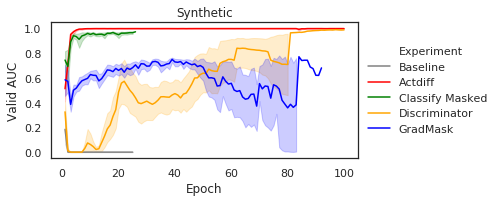

In [185]:
names = [('synth-seeds_resnet', 'Synthetic', -0.05, '')]
plot_curves(names)

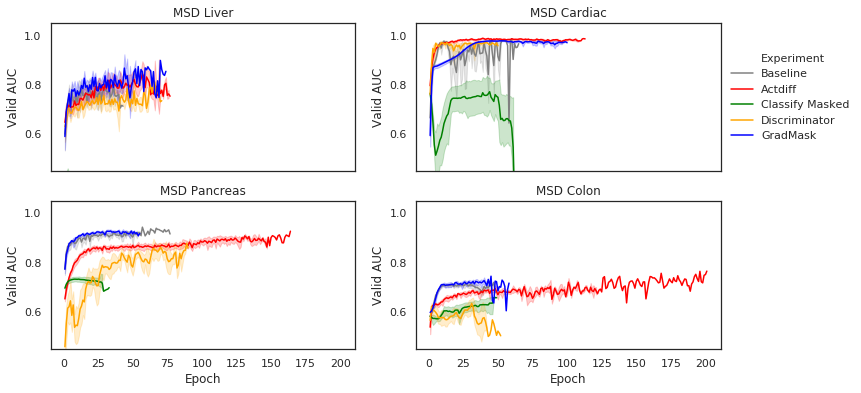

In [180]:
names = [('livermsd-seeds_resnet', 'MSD Liver', 0.45, ''),
         ('cardiacmsd-seeds_resnet', 'MSD Cardiac', 0.45, ''),
         ('pancreasmsd-seeds_resnet', 'MSD Pancreas', 0.45, ''),
         ('colonmsd-seeds_resnet', 'MSD Colon', 0.45, '')
        ]

plot_curves(names)

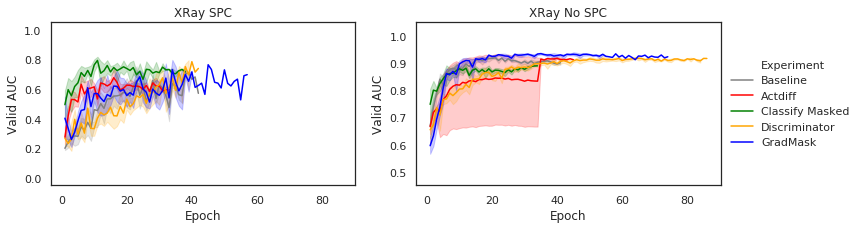

In [181]:
names = [
    ('xray-seeds_resnet', 'XRay SPC', -0.05, 'bal'),
    ('xray-seeds_resnet-bal', 'XRay No SPC', -0.05, '')
    ]
plot_curves(names)

# Datasets

In [ ]:
def view_dataset_wrapper(blur=0, nsamples=10):
    dataset = HeartMSDDataset(
        base_path='/srv/data/msd', mode='test', nsamples=nsamples, blur=blur)
    view_dataset(dataset)

def view_dataset(dataset):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), dpi=72)
    ALPHA = 0.50
    mask_cmap = plt.cm.Reds
    mask_cmap.set_under('k', alpha=0)

    for ax, sample in zip(axs.ravel(), dataset):
        
        x, seg, y = sample

        image = torch.clone(x).detach().cpu().numpy()[0]
        mask = seg.detach().cpu().numpy()[0]
        
        ax.imshow(image, interpolation='none', cmap='Greys_r')
        if y == 1:
            ax.imshow(mask, interpolation='none', cmap=mask_cmap, clim=[0.000001, mask.max()], alpha=ALPHA)
        ax.set_title('label={}'.format(y))

view_dataset_wrapper(blur=2, nsamples=10)

# Mean Saliency Maps / Dataset-Level Stats

In [3]:
#render_mean_grad_wrapper(load_dataset('msd_cardiac', 1234, nsamples=NSAMPLES), 
#                         'cardiacmsd-search', 'MSD Cardiac', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_pancreas', 1234, nsamples=NSAMPLES), 
#                         'pancreasmsd-search', 'MSD Pancreas', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_colon', 1234, nsamples=NSAMPLES), 
#                        'colonmsd-search', 'MSD Colon', size=100, model_name=BEST_MODEL_NAME)
#render_mean_grad_wrapper(load_dataset('msd_liver', 1234, nsamples=NSAMPLES), 
#                        'livermsd-search', 'MSD Liver', size=100, model_name=BEST_MODEL_NAME)

In [ ]:
render_mean_grad_wrapper(load_dataset('synth', 1234, nsamples=10), 
                         'synth-search', 'Synthetic', size=28, model_name=BEST_MODEL_NAME)

In [ ]:
render_mean_grad_wrapper(load_dataset('xray', 1234, nsamples=NSAMPLES), 
                         'xray-search', 'XRay SPC', size=224, 
                         model_name=BEST_MODEL_NAME, model_type='resnet', absoloute=True)

In [ ]:
render_mean_grad_wrapper(load_dataset('xray_bal', 1234, nsamples=NSAMPLES), 
                         'xray-search', 'XRay No SPC', size=224, 
                         model_name=BEST_MODEL_NAME, model_type='resnet-bal', absoloute=True)


In [ ]:
render_mean_grad_wrapper(load_dataset('rsna', 1234, nsamples=NSAMPLES), 
                         'rsna-search', 'RSNA VPC', size=224, 
                         model_name=BEST_MODEL_NAME, model_type='resnet', absoloute=True,
                         crop_mask=50)

In [ ]:
render_mean_grad_wrapper(load_dataset('rsna_bal', 1234, nsamples=NSAMPLES), 
                         'rsna-search', 'RSNA No VPC', size=224, 
                         model_name=BEST_MODEL_NAME, model_type='resnet-bal', absoloute=True,
                         crop_mask=50)

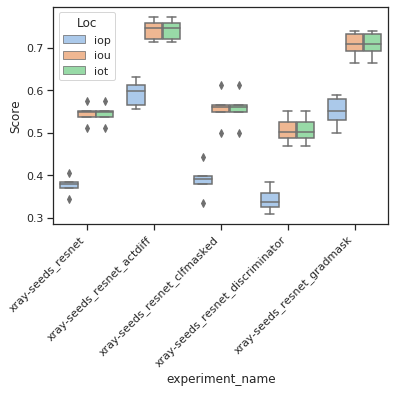

In [244]:
def plot_loc_results(df):
    sns.set(style="ticks", palette="pastel")
    df = df_deduplicate(df)
    df = loc_melt(df)
    plot = sns.boxplot(x="experiment_name", y="Score", hue="Loc", data=df)
    #sns.despine(offset=10, trim=True)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plot_loc_results(df_xray)

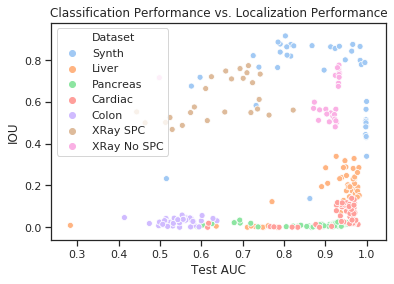

In [278]:
from scipy import stats

def plot_correlation(df):
    g = sns.scatterplot(x="test_auc", 
                        y="iou", 
                        hue='Dataset', 
                        data=df[(np.abs(stats.zscore(df.test_auc)) < 3)])
    g.set_title("Classification Performance vs. Localization Performance")

    g.set_xlabel('Test AUC')
    g.set_ylabel('IOU')

plot_correlation(
    pd.concat([df_deduplicate(df_synth), 
               df_deduplicate(df_msd), 
               df_deduplicate(df_xray), 
               df_deduplicate(df_xray_bal)], axis=0))